### Adapted from paper_ASR_2016Mac.ipynb

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob as glob
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset

import matplotlib.colors as colors
import matplotlib.cm as cmx
from itertools import product

import time
from datetime import datetime

import scipy.io as sio

import matplotlib.tri as tri

from mpl_toolkits.basemap import Basemap

import cmocean #--> to install

In [3]:
def noband(SSH_obs,lon,lat):
    """
    adaf
    """
    size_obs = SSH_obs.shape #before ss4
    dlon = np.diff(lon[30,:])  # 30 = arbitrary row (indices will be the same for the rest of the rows)
    #before dl4
    
    if (np.any(dlon>0.03)): #  if the half-swath trail present in the pass there will be 2 longitude jumps of ~0.1 instead of all ~0.02
            ff = np.ma.masked_all((size_obs[0], 4))
            SSH_obsnb = np.ma.empty((size_obs[0], size_obs[1]+8))
            SSH_obsnb[:, 0:26] = SSH_obs[:, 0:26]  # HAVE TO PUT ONE EXTRA INDEX WHEN DOING A RANGE 
            SSH_obsnb[:, 26:30] = ff[:]
            SSH_obsnb[:, 30] = SSH_obs[:, 26]
            SSH_obsnb[:, 31:35] = ff[:]
            SSH_obsnb[:, 35:-1] = SSH_obs[:, 27:-1]
            SSH_obsnb[:, -1] = SSH_obs[:, -1]

            lonnb = np.ma.empty((size_obs[0], size_obs[1]+8))
            lonnb[:, 0:26] = lon[:, 0:26]
            lonnb[:, 26:30] = lon.max()-2  #ff[:]       
            lonnb[:, 30] = lon[:, 26]
            lonnb[:, 31:35] = lon.max()-2  #ff[:]
            lonnb[:, 35:-1] = lon[:, 27:-1]
            lonnb[:, -1] = lon[:, -1]

            latnb = np.ma.empty((size_obs[0], size_obs[1]+8))
            latnb[:, 0:26] = lat[:, 0:26]
            latnb[:, 26:30] = lat.max()-2 #ff[:]       
            latnb[:, 30] = lat[:, 26]
            latnb[:, 31:35] = lat.max()-2  # ff[:]
            latnb[:, 35:-1] = lat[:, 27:-1]
            latnb[:, -1] = lat[:, -1]
            
    elif (np.any(dlon<-0.03)): #  if the half-swath trail present in the pass there will be 2 longitude jumps of ~0.1 instead of all ~0.02
            ff = np.ma.masked_all((size_obs[0], 4))
            SSH_obsnb = np.ma.empty((size_obs[0], size_obs[1]+8))
            SSH_obsnb[:, 0:26] = SSH_obs[:, 0:26]  # HAVE TO PUT ONE EXTRA INDEX WHEN DOING A RANGE 
            SSH_obsnb[:, 26:30] = ff[:]
            SSH_obsnb[:, 30] = SSH_obs[:, 26]
            SSH_obsnb[:, 31:35] = ff[:]
            SSH_obsnb[:, 35:-1] = SSH_obs[:, 27:-1]
            SSH_obsnb[:, -1] = SSH_obs[:, -1]

            lonnb = np.ma.empty((size_obs[0], size_obs[1]+8))
            lonnb[:, 0:26] = lon[:, 0:26]
            lonnb[:, 26:30] = lon.max()-2  #ff[:]       
            lonnb[:, 30] = lon[:, 26]
            lonnb[:, 31:35] = lon.max()-2  #ff[:]
            lonnb[:, 35:-1] = lon[:, 27:-1]
            lonnb[:, -1] = lon[:, -1]

            latnb = np.ma.empty((size_obs[0], size_obs[1]+8))
            latnb[:, 0:26] = lat[:, 0:26]
            latnb[:, 26:30] = lat.max()-2 #ff[:]       
            latnb[:, 30] = lat[:, 26]
            latnb[:, 31:35] = lat.max()-2  # ff[:]
            latnb[:, 35:-1] = lat[:, 27:-1]
            latnb[:, -1] = lat[:, -1]

    else:  # leave SSH_obs, lon and lat as they are
            SSH_obsnb = SSH_obs       
            lonnb = lon        
            latnb = lat
            
    return SSH_obsnb, lonnb, latnb


In [5]:
mbox = sio.loadmat('/Users/laura/Documents/scripts/IMEDEA/data/3739box.mat')
lon_sat_b1 = mbox['lonobox']
lat_sat_b1 = mbox['latobox']
SSH_model_b1 = mbox['ssh_modelobox']

lon_sat_b1[lon_sat_b1 > 180] -= 360
SSH_model_b1 = np.ma.masked_invalid(SSH_model_b1)

mbox = sio.loadmat('/Users/laura/Documents/scripts/IMEDEA/data/378398box.mat')
lon_sat_b2 = mbox['lonobox']
lat_sat_b2 = mbox['latobox']
SSH_model_b2 = mbox['ssh_modelobox']

lon_sat_b2[lon_sat_b2 > 180] -= 360
SSH_model_b2 = np.ma.masked_invalid(SSH_model_b2)

/Users/laura/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in greater


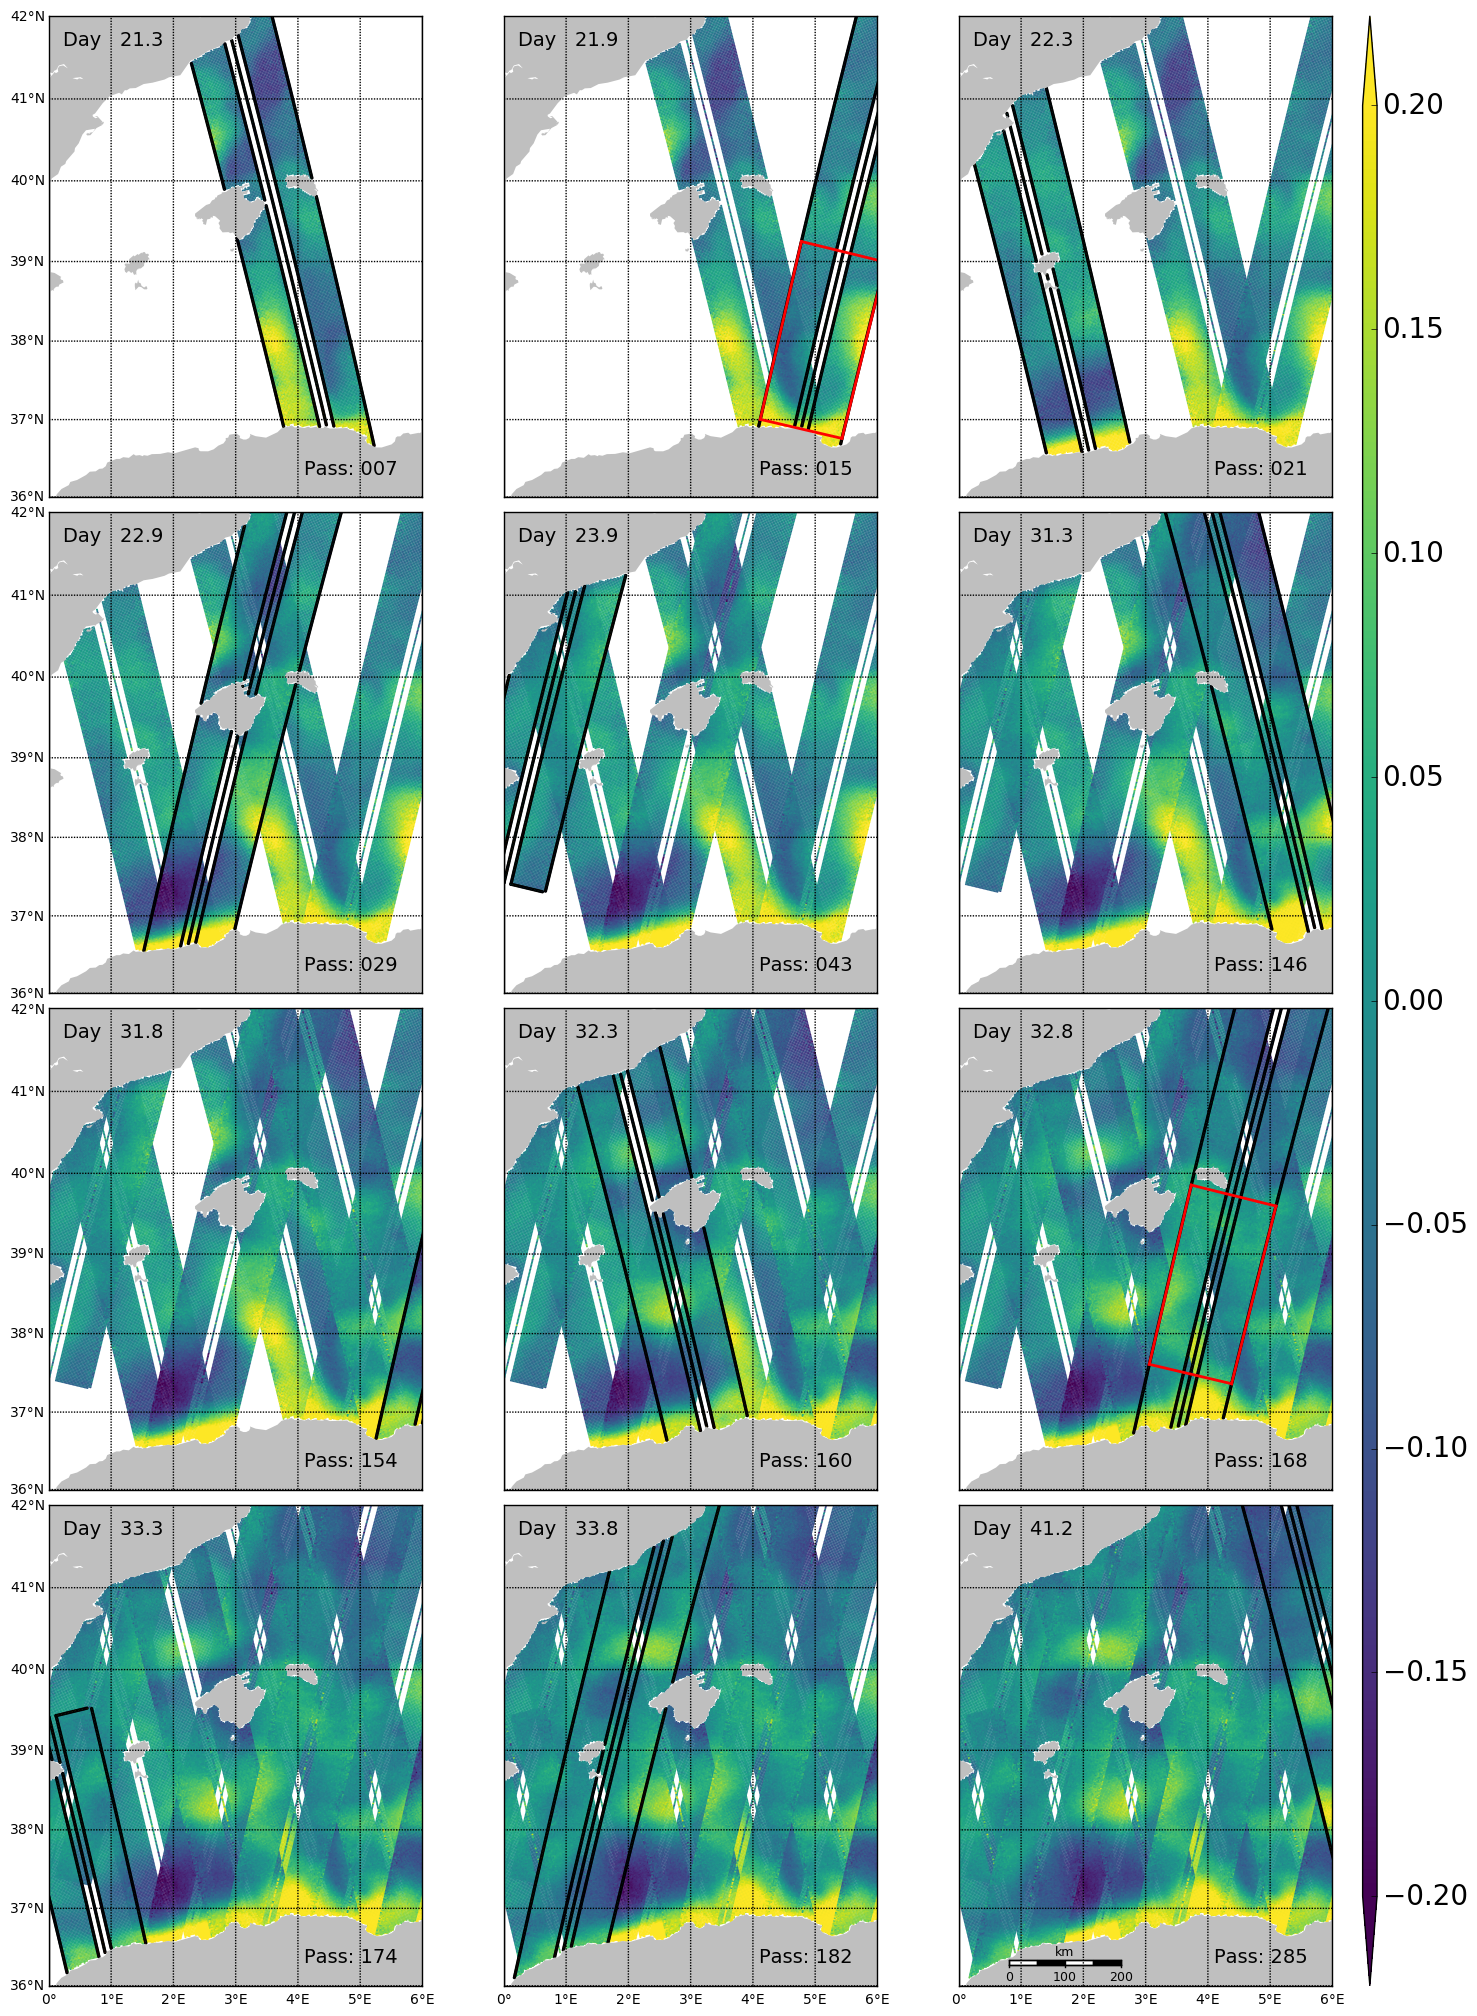

In [6]:
vmin = -0.2
vmax =  0.2

if __name__ == '__main__':
    cmap = 'viridis' #getncvcm('banded', reverse=False, half=0)

    gs = gridspec.GridSpec(4, 4, width_ratios=[0.33, 0.33, 0.33, 0.01], height_ratios=[1, 1, 1, 1])    
    
    fig1 = plt.figure(figsize=(15, 20))  # (w,h)
    #fig1 = plt.figure(figsize=(16, 22.6))  # (w,h) --> A4
    
    directory = '/Users/laura/Documents/scripts/IMEDEA/data/'
    #'/home/lauragomez/Documents/MedStage/swot_output/daily_inputfiles/'

    myfiles = sorted(glob.glob(directory + 'swot_MED_TRY_c02*.nc'))
    myfiles = [ x for x in myfiles if "132" not in x ]
    #This one too? myfiles = [ x for x in myfiles if "154" not in x ] 
    myfiles = [ x for x in myfiles if "196" not in x ]
    
    axc=plt.subplot(gs[:,-1])
    
    steps = np.array([0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14])
    for jj in range(0, len(myfiles)):
        
        ax1 = plt.subplot(gs[steps[jj]])
        
        ##################################################
        # Map
        my_map = Basemap(projection='merc', lat_0=39, lon_0=3, 
            resolution = 'i', area_thresh = 10.0,
            llcrnrlon=0, llcrnrlat=36,
            urcrnrlon=6, urcrnrlat=42, ax=ax1) 
        
        my_map.fillcontinents(color='0.75') # gray #ddaa66 black, coral
        my_map.drawmapboundary()
        if jj==0 or jj==3 or jj==6: 
            my_map.drawmeridians(np.arange(-160, 140, 1), labels=[0,0,0,0])
            my_map.drawparallels(np.arange(0, 70, 1), labels=[1,0,0,1])
        elif (jj==9):
            my_map.drawmeridians(np.arange(-160, 140, 1), labels=[1,0,0,1])
            my_map.drawparallels(np.arange(0, 70, 1), labels=[1,0,0,1])
        elif (jj==10 or jj==11):
            my_map.drawmeridians(np.arange(-160, 140, 1), labels=[1,0,0,1])
            my_map.drawparallels(np.arange(0, 70, 1), labels=[0,0,0,0])
        else:
            my_map.drawmeridians(np.arange(-160, 140, 1), labels=[0,0,0,0])
            my_map.drawparallels(np.arange(0, 70, 1), labels=[0,0,0,0])
            
        xt, yt = my_map(0.22, 41.65)
        xt2, yt2 = my_map(4.1, 36.3)
        
        for ii in range(0, jj+1): ##
            myfile = myfiles[ii]

            with Dataset(myfile) as nc:

                lon = nc.variables['lon'][:]
                lat = nc.variables['lat'][:]
                time_sat = nc.variables['time'][:]
                SSH_obs = nc.variables['SSH_obs'][:]

            lon[lon > 180] -= 360

            # doesn't avoid the pop up message of not monotonically increasing
            #ldif=lon[0,1]-lon[0,0]
            #print(ldif)
            #if (ldif<0):
            #    lon = np.fliplr(lon)
            #    lat = np.fliplr(lat)
            #    #time_sat = np.fliplr(time_sat) # not necessary as 1D
            #    SSH_obs = np.fliplr(SSH_obs)
    
            SSH_obs = np.ma.masked_invalid(SSH_obs)  # to mask certain value

            #SSH_obs = ma.masked_where(lon > 10, SSH_obs)  # to mask values out of domain

            SSH_obsnb, lonnb, latnb = noband(SSH_obs,lon,lat)
            SSH_obsnb2=SSH_obsnb-np.ma.mean(SSH_obsnb)

            # map
            ny_t = SSH_obsnb.shape[0]; nx_t = SSH_obsnb.shape[1]
            lons_t, lats_t = my_map.makegrid(nx_t, ny_t) # get lat/lons of ny by nx evenly space grid.
            x, y = my_map(lons_t, lats_t) # compute map proj coordinates.

            c1=my_map.scatter(lonnb, latnb, c=SSH_obsnb2, linewidth='0', vmin=vmin, vmax=vmax, s=2, latlon=True, cmap=cmap) 
            #c1=my_map.contourf(lonnb, latnb, SSH_obsnb2, levels=ls, latlon=True) 
            c1.set_clim([vmin, vmax])
            if ii==jj:
                my_map.scatter(lonnb[:, 0], latnb[:, 0], c=SSH_obsnb2[:, 0], s=2, latlon=True) 
                my_map.scatter(lonnb[:, -1], latnb[:, -1], c=SSH_obsnb2[:, -1], s=2, latlon=True) 
                my_map.scatter(lonnb[:, 30], latnb[:, 30], c=SSH_obsnb2[:, 30], s=2, latlon=True) 
                my_map.scatter(lonnb[:, 35], latnb[:, 35], c=SSH_obsnb2[:, 35], s=2, latlon=True) 
                my_map.scatter(lonnb[:, 25], latnb[:, 25], c=SSH_obsnb2[:, 25], s=2, latlon=True) 
                my_map.scatter(lonnb[0, :], latnb[0, :], c=SSH_obsnb2[0, :], s=2, latlon=True) 
                my_map.scatter(lonnb[-1, :], latnb[-1, :], c=SSH_obsnb2[-1, :], s=2, latlon=True) 
        
        if jj == len(myfiles) -1:
            my_map.drawmapscale(1.7, 36.3, 3.5, 36.5, 200, barstyle='fancy', yoffset=0.01*(my_map.ymax-my_map.ymin))
        
        timen = np.mean(time_sat)#,decimals=1
        ptm = "Day   %2.1f" % (timen) #
        plt.text(xt, yt, ptm, fontsize=14)
        plt.text(xt2, yt2, 'Pass: ' + myfile[-6:-3], fontsize=14)
        
        if ii == 1:
            my_map.plot((lon_sat_b1[0, 0],lon_sat_b1[-1, 0]), (lat_sat_b1[0,0],lat_sat_b1[-1,0]), linewidth='2', c='r', latlon=True) 
            my_map.plot((lon_sat_b1[0, -1],lon_sat_b1[-1, -1]), (lat_sat_b1[0,-1],lat_sat_b1[-1,-1]), linewidth='2', c='r', latlon=True) 
            my_map.plot((lon_sat_b1[0, 0],lon_sat_b1[0, -1]), (lat_sat_b1[0,0],lat_sat_b1[0,-1]), linewidth='2', c='r', latlon=True) 
            my_map.plot((lon_sat_b1[-1, 0],lon_sat_b1[-1, -1]), (lat_sat_b1[-1,0],lat_sat_b1[-1,-1]), linewidth='2', c='r', latlon=True) 
            
        if ii == 8:
            my_map.plot((lon_sat_b2[0, 0],lon_sat_b2[-1, 0]), (lat_sat_b2[0,0],lat_sat_b2[-1,0]), linewidth='2', c='r', latlon=True) 
            my_map.plot((lon_sat_b2[0, -1],lon_sat_b2[-1, -1]), (lat_sat_b2[0,-1],lat_sat_b2[-1,-1]), linewidth='2', c='r', latlon=True) 
            my_map.plot((lon_sat_b2[0, 0],lon_sat_b2[0, -1]), (lat_sat_b2[0,0],lat_sat_b2[0,-1]), linewidth='2', c='r', latlon=True) 
            my_map.plot((lon_sat_b2[-1, 0],lon_sat_b2[-1, -1]), (lat_sat_b2[-1,0],lat_sat_b2[-1,-1]), linewidth='2', c='r', latlon=True) 
            
    cbar = plt.colorbar(c1, cax=axc, extend='both')
    cbar.ax.tick_params(labelsize=20)

    plt.tight_layout()
    
    savename = '/Users/laura/Documents/scripts/IMEDEA/paperASR/new_version_remote_sensing/figs/' + 'daily_inputs_cycle2_gradual.jpeg'
    plt.savefig(str(savename), bbox_inches='tight', dpi=300)
    
    savename = '/Users/laura/Documents/scripts/IMEDEA/paperASR/new_version_remote_sensing/figs/reduced/' + 'daily_inputs_cycle2_gradual_LOWres.jpeg'
    plt.savefig(str(savename), bbox_inches='tight', dpi=80)
    
    plt.show() 


# Final image as graphical abstract:
To do

In [ ]:
vmin = -0.2
vmax =  0.2

if __name__ == '__main__':
    cmap = 'viridis' #getncvcm('banded', reverse=False, half=0)
    
    fig1 = plt.figure(figsize=(15, 20))  # (w,h)
    #fig1 = plt.figure(figsize=(16, 22.6))  # (w,h) --> A4
    
    directory = '/Users/laura/Documents/scripts/IMEDEA/data/'
    #'/home/lauragomez/Documents/MedStage/swot_output/daily_inputfiles/'

    myfiles = sorted(glob.glob(directory + 'swot_MED_TRY_c02*.nc'))
    myfiles = [ x for x in myfiles if "132" not in x ]
    #This one too? myfiles = [ x for x in myfiles if "154" not in x ] 
    myfiles = [ x for x in myfiles if "196" not in x ]
        
    for jj in range(0, len(myfiles)):
        
        ##################################################
        # Map
        my_map = Basemap(projection='merc', lat_0=39, lon_0=3, 
            resolution = 'i', area_thresh = 10.0,
            llcrnrlon=0, llcrnrlat=36,
            urcrnrlon=6, urcrnrlat=42, ax=ax1) 
        
        my_map.fillcontinents(color='0.75') # gray #ddaa66 black, coral
        my_map.drawmapboundary()
        
        #my_map.drawmeridians(np.arange(-160, 140, 1), labels=[0,0,0,0])
        #my_map.drawparallels(np.arange(0, 70, 1), labels=[0,0,0,0])

        xt, yt = my_map(0.22, 41.65)
        xt2, yt2 = my_map(4.1, 36.3)
        
        for ii in range(0, jj+1): ##
            myfile = myfiles[ii]

            with Dataset(myfile) as nc:

                lon = nc.variables['lon'][:]
                lat = nc.variables['lat'][:]
                time_sat = nc.variables['time'][:]
                SSH_obs = nc.variables['SSH_obs'][:]

            lon[lon > 180] -= 360
    
            SSH_obs = np.ma.masked_invalid(SSH_obs)  # to mask certain value

            #SSH_obs = ma.masked_where(lon > 10, SSH_obs)  # to mask values out of domain

            SSH_obsnb, lonnb, latnb = noband(SSH_obs,lon,lat)
            SSH_obsnb2=SSH_obsnb-np.ma.mean(SSH_obsnb)

            # map
            ny_t = SSH_obsnb.shape[0]; nx_t = SSH_obsnb.shape[1]
            lons_t, lats_t = my_map.makegrid(nx_t, ny_t) # get lat/lons of ny by nx evenly space grid.
            x, y = my_map(lons_t, lats_t) # compute map proj coordinates.

            c1=my_map.scatter(lonnb, latnb, c=SSH_obsnb2, linewidth='0', vmin=vmin, vmax=vmax, s=2, latlon=True, cmap=cmap) 
            #c1=my_map.contourf(lonnb, latnb, SSH_obsnb2, levels=ls, latlon=True) 
            c1.set_clim([vmin, vmax])
            if ii==jj:
                my_map.scatter(lonnb[:, 0], latnb[:, 0], c=SSH_obsnb2[:, 0], s=2, latlon=True) 
                my_map.scatter(lonnb[:, -1], latnb[:, -1], c=SSH_obsnb2[:, -1], s=2, latlon=True) 
                my_map.scatter(lonnb[:, 30], latnb[:, 30], c=SSH_obsnb2[:, 30], s=2, latlon=True) 
                my_map.scatter(lonnb[:, 35], latnb[:, 35], c=SSH_obsnb2[:, 35], s=2, latlon=True) 
                my_map.scatter(lonnb[:, 25], latnb[:, 25], c=SSH_obsnb2[:, 25], s=2, latlon=True) 
                my_map.scatter(lonnb[0, :], latnb[0, :], c=SSH_obsnb2[0, :], s=2, latlon=True) 
                my_map.scatter(lonnb[-1, :], latnb[-1, :], c=SSH_obsnb2[-1, :], s=2, latlon=True) 
        
        if jj == len(myfiles) -1:
            my_map.drawmapscale(1.7, 36.3, 3.5, 36.5, 200, barstyle='fancy', yoffset=0.01*(my_map.ymax-my_map.ymin))
          
    cbar = plt.colorbar(c1, cax=axc, extend='both')
    cbar.ax.tick_params(labelsize=20)

    plt.tight_layout()
    
    savename = '/Users/laura/Documents/scripts/IMEDEA/paperASR/new_version_remote_sensing/figs/' + 'daily_inputs_cycle2_gradual.jpeg'
    plt.savefig(str(savename), bbox_inches='tight', dpi=300)
    
    plt.show() 
